# Data

We will load the data from a specific path.

In [ ]:
import pandas as pd

dataset = pd.read_csv("data/1a_3d_200s_0.5ir_4321_2025-08-10.csv")

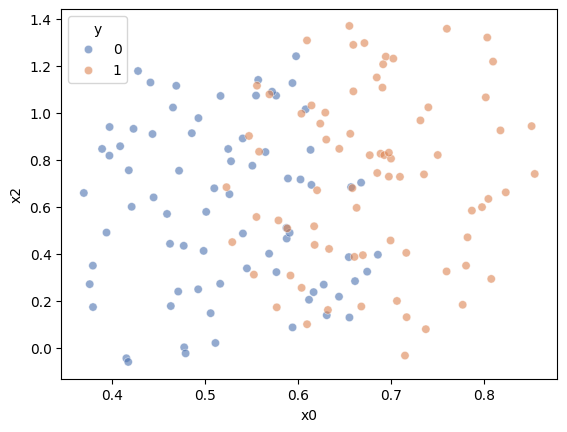

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    x=dataset["x0"], y=dataset["x2"], alpha=0.6, hue=dataset["y"], palette="deep"
)
plt.show()

In [3]:
X_sample = dataset.drop(columns=["y"])
y_sample = dataset["y"]

## Preprocessing step

Based on feature correlation.

In [4]:
from kernel_trainer.preprocess import Preprocessor

# Number of dimensions
num_dimensions = 2
prep = Preprocessor(num_dimensions, mode="pca", scale=True)
X_reduced = prep.fit_transform(X_sample)

In [5]:
from sklearn.model_selection import train_test_split

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y_sample, test_size=0.20, random_state=42
)

# Kernel trainer

In [ ]:
from kernel_trainer import kernel_generator

n_pop = 10
n_gen = 2
chain = 10
mutation_pb = 0.6
cx_prob = 0.3

pop_final, log, _ = kernel_generator(
    X_train,
    y_train,
    num_pop=n_pop,
    ngen=n_gen,
    cxpb=cx_prob,
    mutpb=mutation_pb,
    chain_size=chain,
    penalize_complexity=False,
)

2025-05-25 10:17:05.526 | INFO     | kernel_trainer.main:kernel_generator:133 - gen	nevals	ts	avg     	std      	min     	max     
0  	10    	0 	0.378991	0.0218638	0.350054	0.410257
2025-05-25 10:17:48.761 | INFO     | kernel_trainer.main:kernel_generator:159 - 1  	4     	43.2333	0.387824	0.0128206	0.368586	0.410257
2025-05-25 10:18:48.961 | INFO     | kernel_trainer.main:kernel_generator:159 - 2  	7     	60.1985	0.392631	0.0124444	0.370818	0.410257


In [7]:
best = pop_final[0]
best

Individual([2, 3, 1, 2, 1, 0, 1, 3, 3, 1])

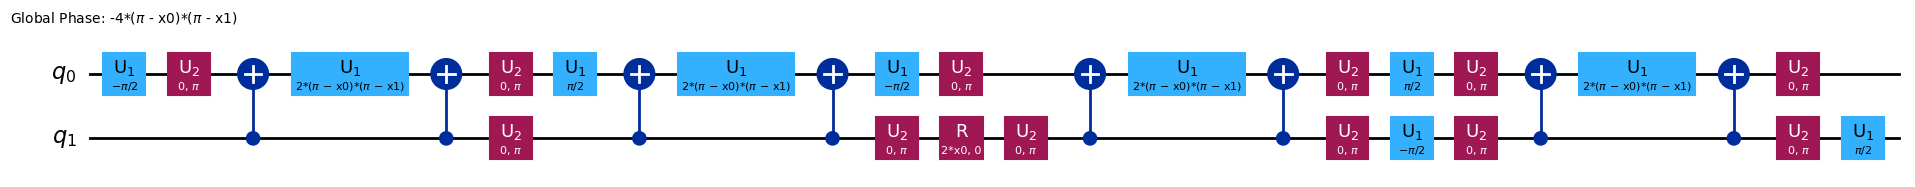

In [ ]:
from qiskit import QuantumCircuit
from kernel_trainer.kernels.quantum import ind_to_qiskit_kernel

qc = QuantumCircuit(X_train.shape[1])

kernel_auto = ind_to_qiskit_kernel(best, qc)
kernel_auto.feature_map.decompose().draw("mpl", fold=-1)

In [9]:
kernel_auto.feature_map.depth()

24

In [10]:
kernel_auto.feature_map.num_nonlocal_gates()

8

In [11]:
ops = kernel_auto.feature_map.count_ops()
sum([n for _, n in ops.items()])

31

(<Figure size 1300x300 with 1 Axes>, <Axes: >)


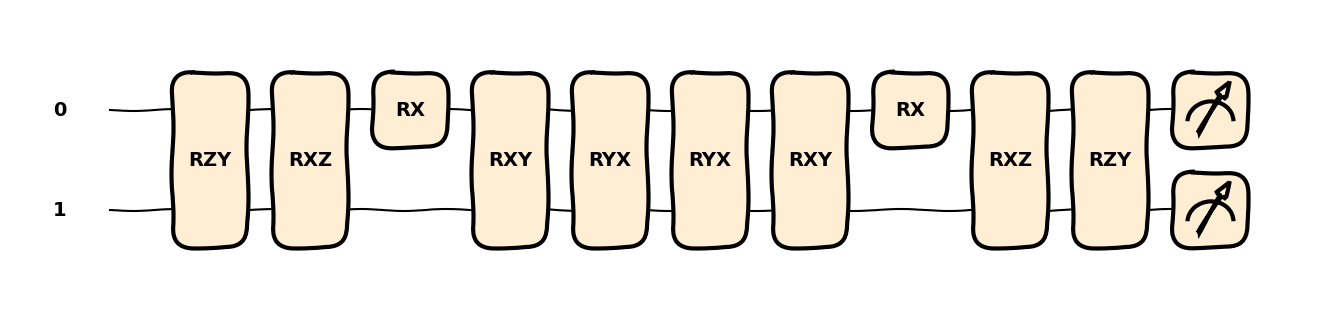

In [ ]:
import pennylane as qml
from kernel_trainer.kernels.quantum import ind_to_pennylane_kernel

qml.drawer.use_style("sketch")

dev = qml.device("lightning.qubit", wires=num_dimensions)

kernel_auto = ind_to_pennylane_kernel(pop_final[0], dev)
print(qml.draw_mpl(kernel_auto)(X_train[0], X_train[0]))

In [13]:
specs = qml.specs(qnode=kernel_auto)(X_train[0], X_train[0])
specs["resources"]

num_wires: 2
num_gates: 10
depth: 10
shots: Shots(total=None)
gate_types:
{'PauliRot': 10}
gate_sizes:
{2: 8, 1: 2}


/home/iraitz/Documentos/Falcondale/FalcondalePro/kernel-trainer/.venv/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:265: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)


In [14]:
specs["resources"].depth

10

In [15]:
specs["resources"].gate_types["PauliRot"]

10

Now running with Pennylane backend.

In [ ]:
backend = "pennylane"

pop_final, log, _ = kernel_generator(
    X_train,
    y_train,
    backend=backend,
    num_pop=n_pop,
    ngen=n_gen,
    cxpb=cx_prob,
    mutpb=mutation_pb,
    chain_size=chain,
)

(<Figure size 1500x300 with 1 Axes>, <Axes: >)


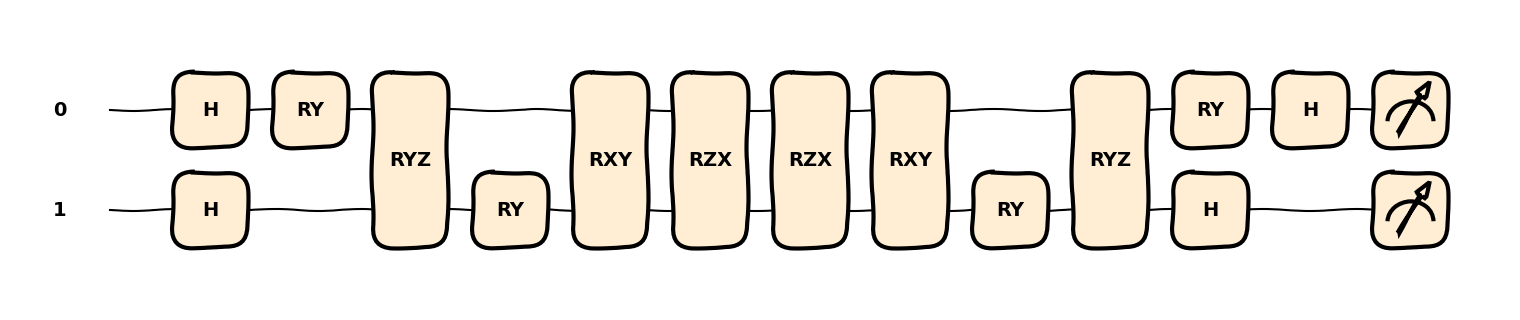

In [10]:
kernel_auto = ind_to_pennylane_kernel(pop_final[0], dev)
print(qml.draw_mpl(kernel_auto)(X_train[0], X_train[0]))